# Об авторе
ФИ: Таначева Анастасия

Дата: 29.06.2025

# Разработка A/B-тестирования и анализ результатов

Вы работаете продуктовым аналитиком в компании, которая разрабатывает развлекательное приложение с функцией «бесконечной» ленты, как, например, в приложениях с короткими видео. В вашем приложении существует две модели монетизации: первая — ежемесячная платная подписка, которая позволяет пользователям смотреть ленту без рекламы, вторая — демонстрация рекламы для пользователей, которые ещё не оформили подписку.

Команда разработчиков рекомендательных систем создала новый алгоритм рекомендаций, который, по их мнению, будет показывать более интересный контент для каждого пользователя. Вас, как аналитика, просят помочь рассчитать параметры A/B-теста, который позволит проверить эту гипотезу, и проанализировать его результаты.

## Описание данных

Вы будете работать с тремя таблицами:

- `sessions_project_history.csv` — таблица с историческими данными по сессиям пользователей на период с 2025-08-11 по 2025-09-23. Путь к файлу: `/datasets/sessions_project_history.csv`.

- `sessions_project_test_part.csv` — таблица с данными за первый день проведения A/B-теста, то есть за 2025-10-14. Путь к файлу: `/datasets/sessions_project_test_part.csv`.

- `sessions_project_test.csv` — таблица с данными за весь период проведения A/B-теста, то есть с 2025-10-14 по 2025-11-02. Путь к файлу: `/datasets/sessions_project_test.csv`.

У этих таблиц почти совпадает структура и содержание колонок, различаются лишь периоды наблюдения.

Поля таблиц `sessions_project_history.csv`, `sessions_project_test.csv`, `sessions_project_test_part.csv`:

- `user_id` — идентификатор пользователя;

- `session_id` — идентификатор сессии в приложении;

- `session_date` — дата сессии;

- `session_start_ts` — дата и время начала сессии;

- `install_date` — дата установки приложения;

- `session_number` — порядковый номер сессии для конкретного пользователя;

- `registration_flag` — является ли пользователь зарегистрированным;

- `page_counter` — количество просмотренных страниц во время сессии;

- `region` — регион пользователя;

- `device` — тип устройства пользователя;

- `test_group` — тестовая группа (в таблице с историческими данными этого столбца нет).


## Что нужно сделать
Ваши задачи: рассчитать параметры теста, оценить корректность его проведения и проанализировать результаты эксперимента.

###### Особенности A/B теста: 
Метрика, по которой ожидается изменение, - доля успешных сессий (отношение количества успешных сессий к общему количеству сессий)

Другие метрики, которые будут тестироваться, - количество пользователей и регистраций, количество просматриваемых страниц.

Ожидаемый эффект - пользователи, которым будут показаны рекомендации на основе нового алгоритма, будут более вовлечены в использвоание приложения (проведут большее количество сессий). 

### 1. Работа с историческими данными (EDA)

#### 1.1. Загрузка исторических данных
На первом этапе поработайте с историческими данными приложения:

- Импортируйте библиотеку pandas.

- Считайте и сохраните в датафрейм `sessions_history` CSV-файл с историческими данными о сессиях пользователей `sessions_project_history.csv`.

Выведите на экран первые пять строк полученного датафрейма.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize
from math import ceil
import seaborn as sns
import statsmodels.stats.proportion as proportion

In [2]:
sessions_history = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_history.csv')

In [3]:
display(sessions_history.head())

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android


#### 1.2. Знакомство с данными
- Для каждого уникального пользователя `user_id` рассчитайте количество уникальных сессий `session_id`.

- Выведите на экран все данные из таблицы `sessions_history` для одного пользователя с наибольшим количеством сессий. Если таких пользователей несколько, выберите любого из них.

- Изучите таблицу для одного пользователя, чтобы лучше понять логику формирования каждого столбца данных.



In [4]:
# Рассчитаем кол-во уникальных сессий для каждого пользователя
user_session_counts = sessions_history.groupby('user_id')['session_id'].nunique()

# Найдем пользователя с наибольшим кол-вом сессий
user_with_max_sessions = user_session_counts.idxmax()

# Выведем все данные для такого пользователя
user_data = sessions_history[sessions_history['user_id'] == user_with_max_sessions]

display(user_data)

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
115558,10E0DEFC1ABDBBE0,B8F0423BBFFCF5DC,2025-08-14,2025-08-14 13:57:39,2025-08-14,1,0,4,CIS,Android
191751,10E0DEFC1ABDBBE0,87CA2FA549473837,2025-08-15,2025-08-15 16:42:10,2025-08-14,2,0,3,CIS,Android
239370,10E0DEFC1ABDBBE0,4ADD8011DCDCE318,2025-08-16,2025-08-16 19:53:21,2025-08-14,3,0,3,CIS,Android
274629,10E0DEFC1ABDBBE0,DF0FD0E09BF1F3D7,2025-08-17,2025-08-17 15:03:43,2025-08-14,4,0,1,CIS,Android
302501,10E0DEFC1ABDBBE0,3C221774B4DE6885,2025-08-18,2025-08-18 17:29:14,2025-08-14,5,0,4,CIS,Android
325557,10E0DEFC1ABDBBE0,031BD7A67048105B,2025-08-19,2025-08-19 13:23:55,2025-08-14,6,0,2,CIS,Android
345336,10E0DEFC1ABDBBE0,FF4315CF4AD4B100,2025-08-20,2025-08-20 19:31:54,2025-08-14,7,0,2,CIS,Android
377532,10E0DEFC1ABDBBE0,4045FEA0747203B4,2025-08-22,2025-08-22 17:54:13,2025-08-14,8,0,2,CIS,Android
403538,10E0DEFC1ABDBBE0,344B086C421C7F37,2025-08-24,2025-08-24 14:46:13,2025-08-14,9,0,2,CIS,Android
414743,10E0DEFC1ABDBBE0,054F20BA371E4C9D,2025-08-25,2025-08-25 18:36:41,2025-08-14,10,0,3,CIS,Android


#### 1.3. Анализ числа регистраций
Одна из важнейших метрик продукта — число зарегистрированных пользователей. Используя исторические данные, визуализируйте, как менялось число регистраций в приложении за время его существования.

- Агрегируйте исторические данные и рассчитайте число уникальных пользователей и число зарегистрированных пользователей для каждого дня наблюдения. Для простоты считайте, что у пользователя в течение дня бывает одна сессия максимум и статус регистрации в течение одного дня не может измениться.

- Постройте линейные графики общего числа пользователей и общего числа зарегистрированных пользователей по дням. Отобразите их на одном графике.

- Постройте отдельный линейный график доли зарегистрированных пользователей от всех пользователей по дням.

- На обоих графиках должны быть заголовок, подписанные оси X и Y, сетка и легенда.

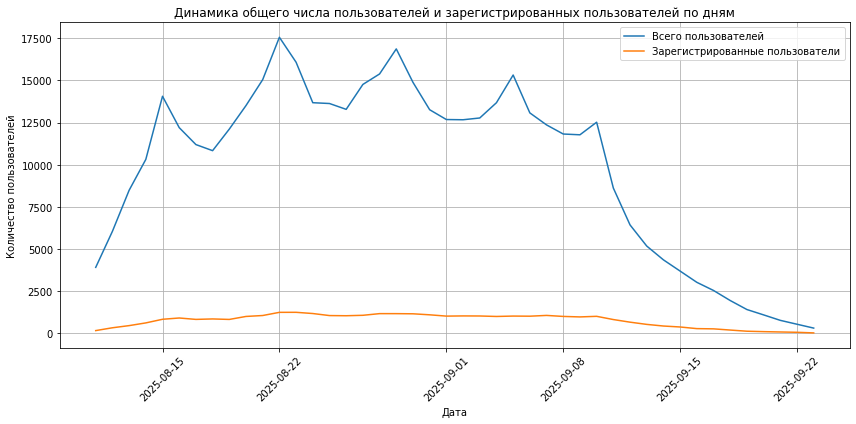

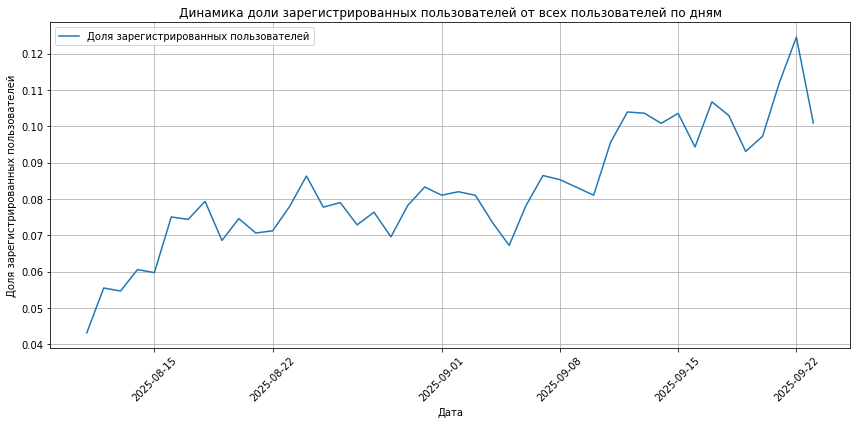

In [5]:
# Преобразование типов данных
sessions_history['session_date'] = pd.to_datetime(sessions_history['session_date'])
sessions_history['install_date'] = pd.to_datetime(sessions_history['install_date'])
sessions_history['session_start_ts'] = pd.to_datetime(sessions_history['session_start_ts'])


# Агрегация данных по дням
daily_metrics = sessions_history.groupby('session_date').agg(
    total_users=('user_id', 'nunique'),
    registered_users=('registration_flag', 'sum')
)

# Расчет доли зарегистрированных пользователей
daily_metrics['registration_rate'] = daily_metrics['registered_users'] / daily_metrics['total_users']

# Построение графика общего числа пользователей и зарегистрированных пользователей
plt.figure(figsize=(12, 6))
plt.plot(daily_metrics.index, daily_metrics['total_users'], label='Всего пользователей')
plt.plot(daily_metrics.index, daily_metrics['registered_users'], label='Зарегистрированные пользователи')
plt.title('Динамика общего числа пользователей и зарегистрированных пользователей по дням')
plt.xlabel('Дата')
plt.ylabel('Количество пользователей')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Построение графика доли зарегистрированных пользователей
plt.figure(figsize=(12, 6))
plt.plot(daily_metrics.index, daily_metrics['registration_rate'], label='Доля зарегистрированных пользователей')
plt.title('Динамика доли зарегистрированных пользователей от всех пользователей по дням')
plt.xlabel('Дата')
plt.ylabel('Доля зарегистрированных пользователей')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

###### Выводы:
- число зарегистрированных пользователей было примерно на одном уровне (1,25 тыс. человек) с 15 августа по 8 сентября 2025 года. После 8 сентября наблюдался спад.

- что касается общего числа пользователей, оно было нестабильным. Пиковые значения пришлись на следующие даты: 15, 22, 30 августа, 5 и 10 сентября. После достижения пикового значения в эти даты наблюдался спад, затем - снова рост. Увеличение числа пользователей наблюдалось ближе к концу недели. Максимальное количество пользователей, посетивших сайт, составило 17500 человек.

- доля зарегистрированных пользователей росла неравномерно. Чаще всего пользователи регистрировались в середине недели. 

#### 1.4. Анализ числа просмотренных страниц
Другая важная метрика продукта — число просмотренных страниц в приложении. Чем больше страниц просмотрено, тем сильнее пользователь увлечён контентом, а значит, выше шансы, что он зарегистрируется и оплатит подписку.

- Найдите количество сессий для каждого значения количества просмотренных страниц. Например: одну страницу просмотрели в 29 160 сессиях, две страницы — в 105 536 сессиях и так далее.

- Постройте столбчатую диаграмму, где по оси X будет число просмотренных страниц, по оси Y — количество сессий.

- На диаграмме должны быть заголовок, подписанные оси X и Y.

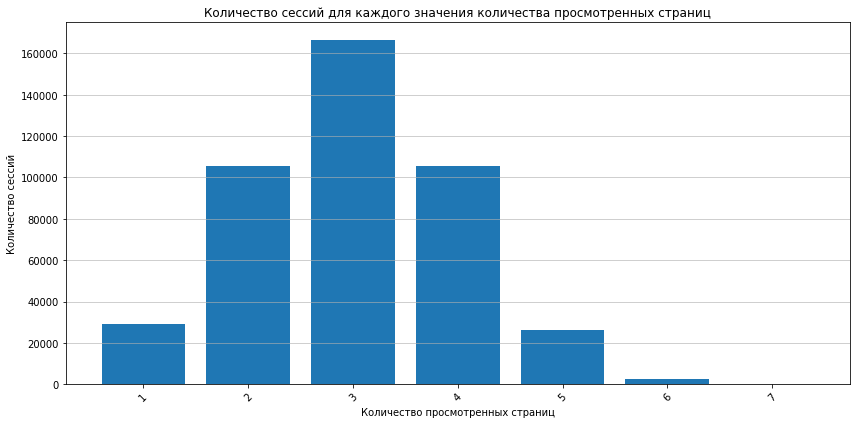

In [6]:
# Группировка данных по количеству просмотренных страниц и подсчет количества сессий
page_views_sessions = sessions_history.groupby('page_counter')['session_id'].count().reset_index()
page_views_sessions.rename(columns={'session_id': 'session_count'}, inplace=True)

# Построение столбчатой диаграммы
plt.figure(figsize=(12, 6))
plt.bar(page_views_sessions['page_counter'], page_views_sessions['session_count'])
plt.xlabel('Количество просмотренных страниц')
plt.ylabel('Количество сессий')
plt.title('Количество сессий для каждого значения количества просмотренных страниц')
plt.grid(axis='y', alpha=0.75)
plt.xticks(rotation=45)  
plt.tight_layout()         
plt.show()

###### Выводы:
- чаще всего пользователи просматривали три страницы (больше 16 тыс. сессий). 

- число сессий для просмотренных двух и четырех страниц превышает 10 тыс.

- одну страницу просматривали в 30 тыс. сессиях, пять страниц - в 25 тыс. сессиях. Шесть страниц просматривали в незначительном количестве сессий, семь страниц не просматривали вообще.  

#### 1.5. Доля пользователей, просмотревших более четырёх страниц
Продуктовая команда продукта считает, что сессии, в рамках которых пользователь просмотрел 4 и более страниц, говорят об удовлетворённости контентом и алгоритмами рекомендаций. Этот показатель является важной прокси-метрикой для продукта.

- В датафрейме `sessions_history` создайте дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если было просмотрено меньше.

- Постройте график со средним значением доли успешных сессий от всех сессий по дням за весь период наблюдения.

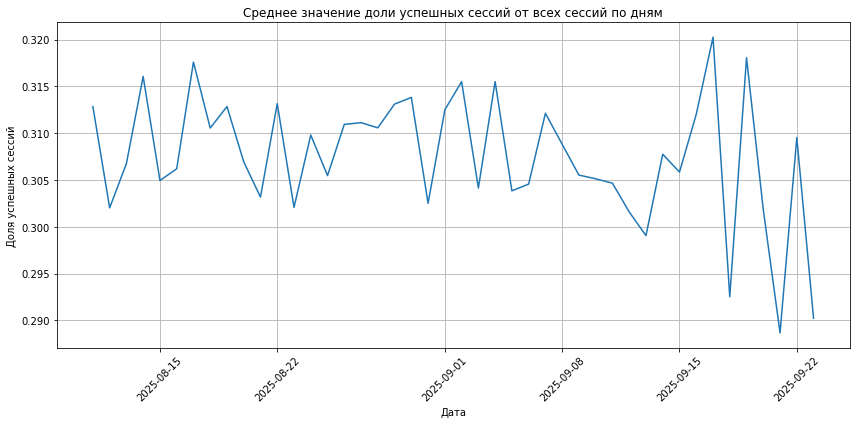

In [7]:
# Создание столбца 'good_session'
sessions_history['good_session'] = (sessions_history['page_counter'] >= 4).astype(int)

# Агрегация данных по дням и расчет доли успешных сессий
daily_good_session_rate = sessions_history.groupby('session_date')['good_session'].mean()

# Построение графика
plt.figure(figsize=(12, 6))
plt.plot(daily_good_session_rate.index, daily_good_session_rate.values)
plt.title('Среднее значение доли успешных сессий от всех сессий по дням')
plt.xlabel('Дата')
plt.ylabel('Доля успешных сессий')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

###### Выводы: 
- среднее значение доли успешных сессий от общего количества сессий по дням было достаточно не стабильным - на каждой неделе наблюдается как спад, так и рост. Так, на 15 августа доля успешных сессий составила 0,305 об общего числа, тогда как на неделе до 22 августа показатель достигал 0,317. 22 августа доля успешных сессий снизилась до 0,313, через неделю, 1 сентября, достигла того же уровня, хотя на неделе, в целом, наблюдался спад. Несмотря на рост доли успешных сессий до 8 сентября (пиковое значение здесь достигло 0,315), 8 сентября доля успешных сессий уменьшилась до 0,308. 

- общее пиковое значение пришлось на неделю с 15 по 22 сентября и достигло 0,32.

### 2. Подготовка к тесту
При планировании теста необходимо проделать несколько важных шагов:

- Сформулировать нулевую и альтернативную гипотезы

- Определиться с целевой метрикой.

- Рассчитать необходимый размер выборки.

- Исходя из текущих значений трафика рассчитать необходимую длительность проведения теста.

#### 2.1 Формулировка нулевой и альтернативной гипотез

Перед тем как проводить А/B-тест, необходимо сформулировать нулевую и альтернативную гипотезы. Напомним изначальное условие: команда разработчиков рекомендательных систем создала новый алгоритм, который, по их мнению, будет показывать более интересный контент для каждого пользователя.

О какой метрике идёт речь? Как она будет учтена в формулировке гипотез?

Сформулируйте нулевую и альтернативную гипотезы:






###### Нулевая гипотеза
Новый алгоритм рекомендаций не оказывает статистически значимого влияния на долю успешных сессий. Это значит, что средняя доля успешных сессий в тестовой группе (с новым алгоритмом) равна средней доле успешных сессий в контрольной группе (со старым алгоритмом).

μ_тестовая = μ_контрольная

###### Альтернативная гипотеза
Новый алгоритм рекомендаций оказывает статистически значимое положительное влияние на долю успешных сессий. То есть, средняя доля успешных сессий в тестовой группе (с новым алгоритмом) выше, чем средняя доля успешных сессий в контрольной группе (со старым алгоритмом).

μ_тестовая > μ_контрольная

#### 2.2. Расчёт размера выборки
В рамках курса вы уже рассчитывали размеры выборки и  использовали для этого онлайн-калькулятор. В этом задании предлагаем воспользоваться готовым кодом и рассчитать необходимое для вашего эксперимента количество пользователей.

Для этого установите в коде ниже следующие параметры:

- Уровень значимости — 0.05.

- Вероятность ошибки второго рода — 0.2.

- Мощность теста.

- Минимальный детектируемый эффект, или MDE, — 3%. Обратите внимание, что здесь нужно указать десятичную дробь, а не процент.

При расчёте размера выборки используйте метод `solve_power()` из класса `power.NormalIndPower` модуля `statsmodels.stats`.

Запустите ячейку и изучите полученное значение.

In [8]:
# Задаём параметры
alpha = 0.05  # Уровень значимости
beta = 0.2  # Ошибка второго рода, часто 1 - мощность
power = 1 - beta  # Мощность теста
p1 = 0.3  # Базовый уровень доли
mde = 0.03 # Минимальный детектируемый эффект
effect_size = proportion_effectsize(p1, p1 + (mde * p1))

# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = effect_size,
    power = power,
    alpha = alpha,
    ratio = 1 # Равномерное распределение выборок
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 41040


#### 2.3. Расчёт длительности A/B-теста

Используйте данные о количестве пользователей в каждой выборке и среднем количестве пользователей приложения. Рассчитайте длительность теста, разделив одно на другое.

- Рассчитайте среднее количество уникальных пользователей приложения в день.

- Определите длительность теста исходя из рассчитанного значения размера выборок и среднего дневного трафика приложения. Количество дней округлите в большую сторону.

In [9]:
# Среднее количество пользователей приложения в день по историческим данным
avg_daily_users = sessions_history.groupby('session_date')['user_id'].nunique().mean()

# Рассчитываем длительность теста в днях как отношение размера выборки к среднему числу пользователей
test_duration = ceil(sample_size*2 / avg_daily_users)

print(f"Рассчитанная длительность A/B-теста при текущем уровне трафика в {avg_daily_users:.2f} пользователей в день составит {test_duration} дней")

Рассчитанная длительность A/B-теста при текущем уровне трафика в 9907.36 пользователей в день составит 9 дней


### 3. Мониторинг А/В-теста

#### 3.1. Проверка распределения пользователей

A/B-тест успешно запущен, и уже доступны данные за первые три дня. На этом этапе нужно убедиться, что всё идёт хорошо: пользователи разделены правильным образом, а интересующие вас метрики корректно считаются.

- Считайте и сохраните в датафрейм `sessions_test_part` CSV-файл с историческими данными о сессиях пользователей `sessions_project_test_part.csv`.

- Рассчитайте количество уникальных пользователей в каждой из экспериментальных групп для одного дня наблюдения.

- Рассчитайте и выведите на экран процентную разницу в количестве пользователей в группах A и B. Постройте любую удобную визуализацию, на которой будет видно возможное различие двух групп.

Для расчёта процентной разницы воспользуйтесь формулой:
$$P = 100 \cdot  \frac{|A − B|}{A}$$

Количество уникальных пользователей в каждой группе:
test_group
A    1477
B    1466
Name: user_id, dtype: int64

Процентная разница в количестве пользователей между группами A и B: 0.74%


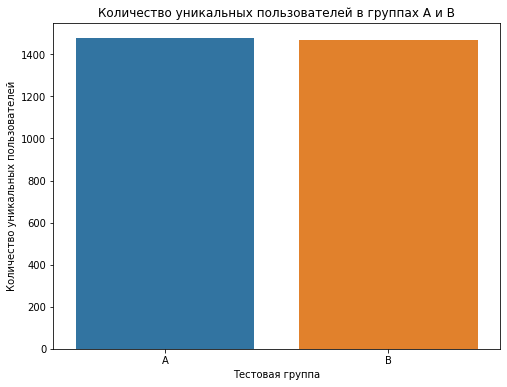

In [10]:
sessions_test_part = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_test_part.csv')

# Рассчитайте количество уникальных пользователей в каждой из экспериментальных групп
user_counts = sessions_test_part.groupby('test_group')['user_id'].nunique()

print("Количество уникальных пользователей в каждой группе:")
print(user_counts)

# Рассчитайте процентную разницу в количестве пользователей в группах A и B
group_a_count = user_counts['A']
group_b_count = user_counts['B']

percentage_difference = 100 * abs(group_a_count - group_b_count) / group_a_count

print(f"\nПроцентная разница в количестве пользователей между группами A и B: {percentage_difference:.2f}%")

# Постройте визуализацию (столбчатая диаграмма)
plt.figure(figsize=(8, 6))
sns.barplot(x=user_counts.index, y=user_counts.values)
plt.title('Количество уникальных пользователей в группах A и B')
plt.xlabel('Тестовая группа')
plt.ylabel('Количество уникальных пользователей')
plt.show()

#### 3.2. Проверка пересечений пользователей
Помимо проверки равенства количества пользователей в группах, полезно убедиться в том, что группы независимы. Для этого нужно убедиться, что никто из пользователей случайно не попал в обе группы одновременно.

- Рассчитайте количество пользователей, которые встречаются одновременно в группах A и B, или убедитесь, что таких нет.

In [11]:
# Создание отдельных списков пользователей для каждой группы
group_a_users = sessions_test_part[sessions_test_part['test_group'] == 'A']['user_id'].unique()
group_b_users = sessions_test_part[sessions_test_part['test_group'] == 'B']['user_id'].unique()

# Поиск пересечения между списками пользователей
common_users = set(group_a_users) & set(group_b_users)

# Вывод результата
if len(common_users) > 0:
    print(f"Обнаружены пользователи, которые присутствуют в обеих группах (A и B): {len(common_users)} пользователей")
    print(f"Список этих пользователей: {common_users}")
else:
    print("Не обнаружено пользователей, которые одновременно присутствуют в обеих группах (A и B).")

Не обнаружено пользователей, которые одновременно присутствуют в обеих группах (A и B).


#### 3.3. Равномерность разделения пользователей по устройствам
Полезно также убедиться в том, что пользователи равномерно распределены по всем доступным категориальным переменным — типам устройств и регионам.

Постройте две диаграммы:

- доля каждого типа устройства для пользователей из группы A,

- доля каждого типа устройства для пользователей из группы B.

Постарайтесь добавить на диаграммы все необходимые подписи, пояснения и заголовки, которые позволят сделать вывод о том, совпадает ли распределение устройств в группах A и B.


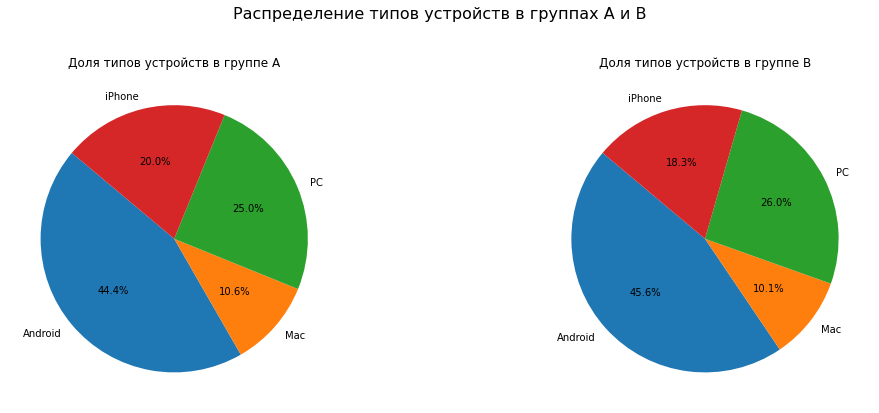

In [12]:
# Подсчет уникальных пользователей)
device_distribution_a = sessions_test_part[sessions_test_part['test_group'] == 'A'].groupby('device')['user_id'].nunique()
device_distribution_b = sessions_test_part[sessions_test_part['test_group'] == 'B'].groupby('device')['user_id'].nunique()

# Рассчитываем общую сумму уникальных пользователей для каждой группы
total_users_a = sessions_test_part[sessions_test_part['test_group'] == 'A']['user_id'].nunique()
total_users_b = sessions_test_part[sessions_test_part['test_group'] == 'B']['user_id'].nunique()

# Пересчитываем доли с учетом общего числа пользователей в группе
device_distribution_a = (device_distribution_a / total_users_a) * 100
device_distribution_b = (device_distribution_b / total_users_b) * 100


# Создание графиков
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# График для группы A
axes[0].pie(device_distribution_a, labels=device_distribution_a.index, autopct='%1.1f%%', startangle=140)
axes[0].set_title('Доля типов устройств в группе A')

# График для группы B
axes[1].pie(device_distribution_b, labels=device_distribution_b.index, autopct='%1.1f%%', startangle=140)
axes[1].set_title('Доля типов устройств в группе B')

plt.suptitle('Распределение типов устройств в группах A и B', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#### 3.4. Равномерность распределения пользователей по регионам
Теперь убедитесь, что пользователи равномерно распределены по регионам.

Постройте две диаграммы:

- доля каждого региона для пользователей из группы A,

- доля каждого региона для пользователей из группы B.

Постарайтесь добавить на диаграммы все необходимые подписи, пояснения и заголовки, которые позволят сделать вывод о том, совпадает ли распределение регионов в группах A и B. Постарайтесь использовать другой тип диаграммы, не тот, что в прошлом задании.


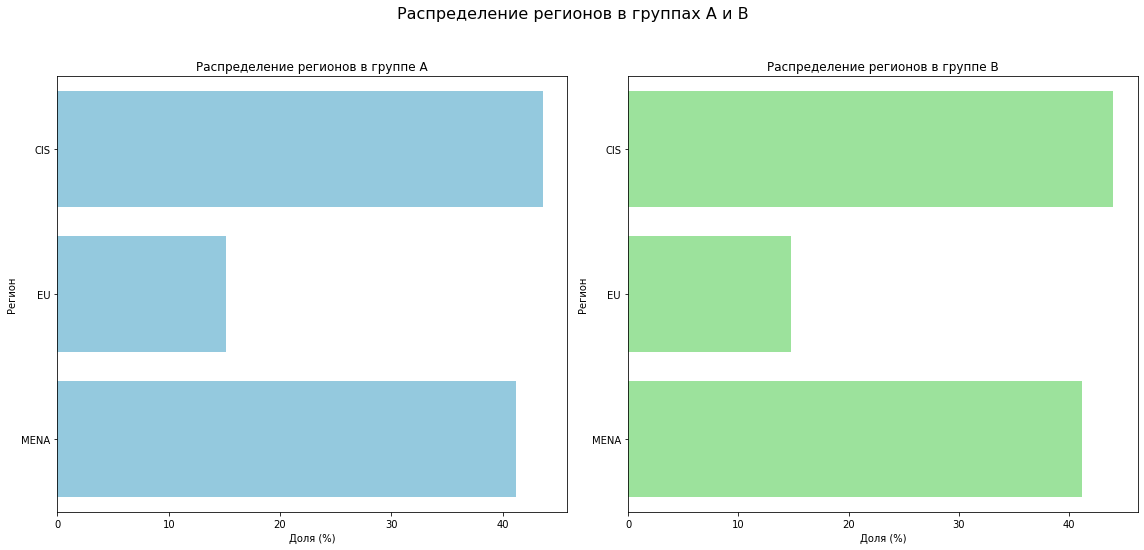

In [13]:
#  Считаем количество уникальных пользователей по регионам для каждой группы
region_distribution_a = sessions_test_part[sessions_test_part['test_group'] == 'A'].groupby('region')['user_id'].nunique()
region_distribution_b = sessions_test_part[sessions_test_part['test_group'] == 'B'].groupby('region')['user_id'].nunique()


# Рассчитываем общую сумму уникальных пользователей для каждой группы
total_users_a = sessions_test_part[sessions_test_part['test_group'] == 'A']['user_id'].nunique()
total_users_b = sessions_test_part[sessions_test_part['test_group'] == 'B']['user_id'].nunique()

# Пересчитываем доли с учетом общего числа пользователей в группе
region_distribution_a = (region_distribution_a / total_users_a) * 100
region_distribution_b = (region_distribution_b / total_users_b) * 100


# Создание графиков (горизонтальные столбчатые диаграммы)
fig, axes = plt.subplots(1, 2, figsize=(16, 8))  # Увеличим высоту для большего количества регионов

# График для группы A
sns.barplot(x=region_distribution_a.values, y=region_distribution_a.index, ax=axes[0], color='skyblue')
axes[0].set_title('Распределение регионов в группе A')
axes[0].set_xlabel('Доля (%)')
axes[0].set_ylabel('Регион')

# График для группы B
sns.barplot(x=region_distribution_b.values, y=region_distribution_b.index, ax=axes[1], color='lightgreen')
axes[1].set_title('Распределение регионов в группе B')
axes[1].set_xlabel('Доля (%)')
axes[1].set_ylabel('Регион')

plt.suptitle('Распределение регионов в группах A и B', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#### 3.5. Вывод после проверки A/B-теста

На основе проведённого анализа A/B-теста сформулируйте и запишите свои выводы. В выводе обязательно укажите:

- Было ли обнаружено различие в количестве пользователей в двух группах.

- Являются ли выборки независимыми. Было ли обнаружено пересечение пользователей из тестовой и контрольной групп.

- Сохраняется ли равномерное распределение пользователей тестовой и контрольной групп по категориальным переменным: устройствам и регионам.

Сделайте заключение: корректно ли проходит A/B-тест, или наблюдаются какие-либо нарушения.

###### Промежуточный вывод
A/B-тест проходит корректно, так как:
- не было обнаружено статистически значимого различия между количеством пользователей в двух группах (1477 - в группе A, 1466 - в группе B);

- не было обнаружено пользователей, которые одновременно присутствуют в обеих группах (A и B);

- можно говорить о равномерном распределении пользователей двух групп по устройствам. Так, например в группе A 10,6% пользователей используют Mac, в группе B их относительное число равно 10,1%. Android в группе A пользуются 44,4%, в группе B - 45,6%, PC в группе А - 25%, в группе B - 26%, iPhone в группе A - 20%, в группе B - 18,3%;  

- что касается распределения по регионам, то его тоже можно назвать равномерным. Так, 43,6% пользователей группы A проживают в CIS, что незначительно ниже числа пользователей из группы B (44%). Также для группы A характерно, что 41,2% пользователей проживают в Mena, как и 41,2% пользователей группы B. Количество проживающих в EU в обеих группах равно и составляет 15,2% (группа A) и 14,8% (группа B).

### 4. Проверка результатов A/B-теста

A/B-тест завершён, и у вас есть результаты за все дни проведения эксперимента. Необходимо убедиться в корректности теста и верно интерпретировать результаты.

#### 4.1. Получение результатов теста и подсчёт основной метрики

- Считайте и сохраните в датафрейм `sessions_test` CSV-файл с историческими данными о сессиях пользователей `sessions_project_test.csv`.

- В датафрейме `sessions_test` создайте дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если просмотрено меньше.

In [14]:
sessions_test = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_test.csv')

# Создание столбца 'good_session'
sessions_test['good_session'] = (sessions_test['page_counter'] >= 4).astype(int)

display(sessions_test.head())

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group,good_session
0,6DAE3B3654DA738E,C69249E26E58F6E2,2025-10-26,2025-10-26 18:15:05,2025-10-16,3,0,3,MENA,Android,A,0
1,0A3FE5D1DD59110A,66D66D7C9F5181B7,2025-10-21,2025-10-21 17:04:53,2025-10-15,2,1,2,CIS,Android,B,0
2,2041F1D7AA740B88,50DE51D42215E74C,2025-10-23,2025-10-23 17:39:29,2025-10-19,3,0,2,MENA,Android,A,0
3,43D7585009168086,5763C0C353C22263,2025-10-24,2025-10-24 15:01:57,2025-10-18,4,0,1,CIS,iPhone,B,0
4,15AD68B14D62D88C,B1AD09F93C1053BC,2025-10-17,2025-10-17 17:34:39,2025-10-17,1,0,2,MENA,Android,B,0


#### 4.2. Проверка корректности результатов теста

Прежде чем приступать к анализу ключевых продуктовых метрик, необходимо убедиться, что тест проведён корректно и вы будете сравнивать две сопоставимые группы.

- Рассчитайте количество уникальных сессий для каждого дня и обеих тестовых групп, используя группировку.

- Проверьте, что количество уникальных дневных сессий в двух выборках не различается или различия не статистически значимыми. Используйте статистический тест, который позволит сделать вывод о равенстве средних двух выборок.

- В качестве ответа выведите на экран полученное значение p-value и интерпретируйте его.

In [15]:
from scipy import stats

# Преобразование типов данных
sessions_test['session_date'] = pd.to_datetime(sessions_test['session_date'])

# Рассчитайте количество уникальных сессий для каждого дня и обеих тестовых групп
daily_sessions = sessions_test.groupby(['session_date', 'test_group'])['session_id'].nunique().unstack()

# Проверьте, что количество уникальных дневных сессий в двух выборках не различается статистически значимо
# Используем t-тест Стьюдента для независимых выборок
t_statistic, p_value = stats.ttest_ind(daily_sessions['A'].dropna(), daily_sessions['B'].dropna(), equal_var=False)

print(f"P-value: {p_value}")

# Интерпретируйте p-value
alpha = 0.05  # Уровень значимости
if p_value < alpha:
    print("Различие в количестве уникальных сессий между группами статистически значимо.")
    print("Нулевая гипотеза о равенстве средних отвергается.")
else:
    print("Различие в количестве уникальных сессий между группами статистически незначимо.")
    print("Нет оснований отвергать нулевую гипотезу.")


P-value: 0.9382195854082714
Различие в количестве уникальных сессий между группами статистически незначимо.
Нет оснований отвергать нулевую гипотезу.


#### 4.3. Сравнение доли успешных сессий

Когда вы убедились, что количество сессий в обеих выборках не различалось, можно переходить к анализу ключевой метрики — доли успешных сессий.

Используйте созданный на первом шаге задания столбец `good_session` и рассчитайте долю успешных сессий для выборок A и B, а также разницу в этом показателе. Полученный вывод отобразите на экране.

In [16]:
# Рассчитайте долю успешных сессий для выборок A и B
good_session_rate = sessions_test.groupby('test_group')['good_session'].mean()

# Рассчитайте разницу в доле успешных сессий
difference = good_session_rate['B'] - good_session_rate['A']

# Вывод результатов на экран
print("Доля успешных сессий в группе A:", good_session_rate['A'])
print("Доля успешных сессий в группе B:", good_session_rate['B'])
print("Разница в доле успешных сессий (B - A):", difference)

Доля успешных сессий в группе A: 0.3077233557344958
Доля успешных сессий в группе B: 0.31828992745867524
Разница в доле успешных сессий (B - A): 0.010566571724179463


#### 4.4. Насколько статистически значимо изменение ключевой метрики

На предыдущем шаге вы убедились, что количество успешных сессий в тестовой выборке примерно на 1.1% выше, чем в контрольной, но делать выводы только на основе этого значения будет некорректно. Для принятия решения всегда необходимо отвечать на вопрос: является ли это изменение статистически значимым.

- Используя статистический тест, рассчитайте, является ли изменение в метрике доли успешных сессий статистически значимым.

- Выведите на экран полученное значение p-value и свои выводы о статистической значимости. Напомним, что уровень значимости в эксперименте был выбран на уровне 0.05.

In [17]:
# Рассчитайте количество успешных сессий и общее количество сессий для каждой группы
successes_a = sessions_test[sessions_test['test_group'] == 'A']['good_session'].sum()
successes_b = sessions_test[sessions_test['test_group'] == 'B']['good_session'].sum()
n_a = len(sessions_test[sessions_test['test_group'] == 'A'])
n_b = len(sessions_test[sessions_test['test_group'] == 'B'])

# Проведите z-тест для пропорций
z_statistic, p_value = proportion.proportions_ztest([successes_b, successes_a], [n_b, n_a], alternative='larger')

print(f"P-value: {p_value}")

# Сравните p-value с уровнем значимости и сделайте выводы
alpha = 0.05
if p_value < alpha:
    print("Изменение в доле успешных сессий статистически значимо.")
    print("Отвергаем нулевую гипотезу о равенстве долей.")
    print("Новый алгоритм (группа B) имеет статистически значимое положительное влияние на долю успешных сессий.")
else:
    print("Изменение в доле успешных сессий статистически незначимо.")
    print("Нет оснований отвергать нулевую гипотезу о равенстве долей.")
    print("Недостаточно оснований утверждать, что новый алгоритм (группа B) оказывает статистически значимое влияние на долю успешных сессий.")

P-value: 0.0001574739988036123
Изменение в доле успешных сессий статистически значимо.
Отвергаем нулевую гипотезу о равенстве долей.
Новый алгоритм (группа B) имеет статистически значимое положительное влияние на долю успешных сессий.


#### 4.5. Вывод по результатам A/B-эксперимента

На основе проведённого анализа результатов теста сформулируйте и запишите свои выводы для команды разработки приложения. В выводе обязательно укажите:

- Характеристики проведённого эксперимента, количество задействованных пользователей и длительность эксперимента.

- Повлияло ли внедрение нового алгоритма рекомендаций на рост ключевой метрики и как.

- Каким получилось значение p-value для оценки статистической значимости выявленного эффекта.

- Стоит ли внедрять нововведение в приложение.

###### Характеристики эксперимента:

- Цель эксперимента: оценка влияния нового алгоритма рекомендаций на долю успешных сессий в приложении. Успешной сессией считается сессия, в которой пользователь просмотрел 4 и более страниц.

- Метрика: доля успешных сессий (отношение количества успешных сессий к общему количеству сессий).

- Продолжительность эксперимента: 9 дней.

-  Количество задействованных пользователей: 41040 (для каждой группы)

-  Группы:
  - Группа A (контрольная группа): Пользователи, которым показывается контент на основе старого алгоритма рекомендаций.
  -  Группа B (тестовая группа): Пользователи, которым показывается контент на основе нового алгоритма рекомендаций.

-  Уровень значимости (alpha): 0.05

Результаты эксперимента:

-  Размер групп: статистически значимых различий в количестве сессий между группами A и B выявлено не было (p-value = 0.9382). Это означает, что трафик был разделен между группами корректно.

-  Доля успешных сессий:
  -  В группе A (старый алгоритм) доля успешных сессий составила 0.3077 (30.77%).
  -  В группе B (новый алгоритм) доля успешных сессий составила 0.3183 (31.83%).
  -  Разница между группами: Доля успешных сессий в группе B на 0.0106 (1.06 процентных пункта) выше, чем в группе A.

-  Статистическая значимость: Результаты z-теста для пропорций показали, что изменение в доле успешных сессий статистически значимо (p-value = 0.000157). Так как p-value меньше установленного уровня значимости (0.05), мы отвергаем нулевую гипотезу о равенстве долей и можем заключить, что новый алгоритм оказывает статистически значимое влияние на долю успешных сессий.


###### Рекомендация:

На основе результатов проведенного A/B-теста, рекомендуется внедрить новый алгоритм рекомендаций в приложение.

Новый алгоритм статистически значимо увеличивает долю успешных сессий на 1.06 процентных пункта. Несмотря на то что это изменение может показаться небольшим, статистическая значимость этого результата позволяет с уверенностью говорить о том, что новый алгоритм действительно оказывает положительное влияние на вовлеченность пользователей. Увеличение доли успешных сессий может привести к увеличению времени, проводимого пользователями в приложении, увеличению количества просмотренных страниц и, как следствие, к увеличению конверсии в регистрацию и подписку.

В целом, A/B-тест показал положительный эффект от внедрения нового алгоритма рекомендаций. Принятие решения о внедрении нововведения подкреплено статистической значимостью полученных результатов и потенциальным положительным влиянием на ключевые бизнес-показатели.